In [1]:
import dask
import dask.dataframe as dd
import dask_geopandas as dg
import datetime as dt
import geopandas as gpd
import glob
import os
import pandas as pd
import sys

from shared_utils import utils
#from utilities import catalog_filepath, GCS_FILE_PATH
from update_vars import analysis_date

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
DASK_GCS = "gs://calitp-analytics-data/data-analyses/dask_test/"

PAIRWISE_FILE = f"{DASK_GCS}intermediate/pairwise.parquet"
SUBSET_CORRIDORS = f"{DASK_GCS}intermediate/subset_corridors.parquet"

In [3]:
intersecting_pairs = pd.read_parquet(PAIRWISE_FILE)

In [22]:
intersecting_pairs.shape

(181496, 4)

In [5]:
corridors = gpd.read_parquet(SUBSET_CORRIDORS)

In [26]:
def find_corresponding_pairs(gdf: gpd.GeoDataFrame, pairs_table: pd.DataFrame, 
                             itp_id: int)-> gpd.GeoDataFrame:
    
    operator = gdf[gdf.calitp_itp_id==itp_id]
    operator_segments = operator.hqta_segment_id.unique().tolist() 
        
    intersecting_routes = (pairs_table[
        pairs_table.hqta_segment_id.isin(operator_segments)]
        .intersect_hqta_segment_id
        .unique().tolist()
    )
    
    corresponding_pairs = (gdf[gdf.hqta_segment_id.isin(intersecting_routes)]
                       [["route_identifier", "hqta_segment_id", "geometry"]]
                       .drop_duplicates()
                       .reset_index(drop=True)
                      )
    
    return corresponding_pairs

In [27]:
corridors = gpd.read_parquet(SUBSET_CORRIDORS)

In [28]:
def clip(operator_df: dg.GeoDataFrame, 
         intersecting_pairs: gpd.GeoDataFrame, 
         operator_routes: list
        ) -> dg.GeoDataFrame:
    
    results = []
    
    for i in operator_routes:
        clipped = dg.clip(
            operator_df[operator_df.route_identifier==i],
            intersecting_pairs[intersecting_pairs.route_identifier != i], 
            keep_geom_type = True
        )
        results.append(clipped)
    
    intersections = dd.multi.concat(results, axis=0).drop_duplicates()

    return intersections

In [29]:
metro = corridors[corridors.calitp_itp_id==182]
metro_pairs = find_corresponding_pairs(corridors, intersecting_pairs, 182)

In [ ]:
test_route = 3588563102

In [ ]:
clipped = gpd.clip(
            metro[metro.route_identifier == test_route],
            metro_pairs[metro_pairs.route_identifier == test_route], 
            keep_geom_type = True
        )

In [31]:
import warnings
warnings.filterwarnings("ignore")

def intersections_for_operator(corridors, itp_id):
    operator_gdf = dg.from_geopandas(
        corridors[corridors.calitp_itp_id==itp_id], npartitions=1)
    
    pairs = find_corresponding_pairs(corridors, intersecting_pairs, itp_id)
    
    operator_routes = (corridors[corridors.calitp_itp_id==itp_id]
                      .route_identifier.unique().tolist()
                      )
        
    results = clip(operator_gdf, pairs, operator_routes)
    
    return results

In [32]:
metro = intersections_for_operator(corridors, 182).compute()

<AxesSubplot:>

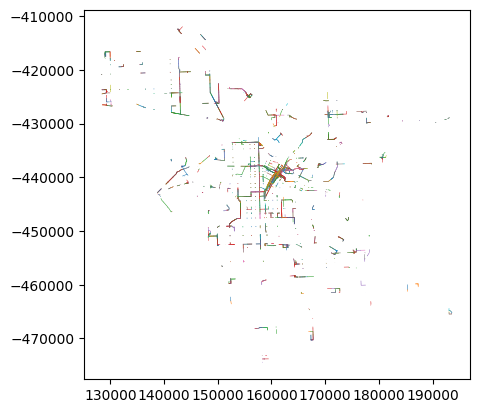

In [34]:
metro.plot("segment_sequence")

<AxesSubplot:>

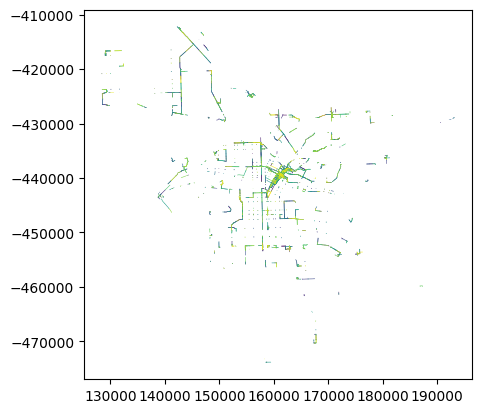

In [46]:
metro_old.plot("hqta_segment_id")

In [36]:
bbb = intersections_for_operator(corridors, 300).compute()

<AxesSubplot:>

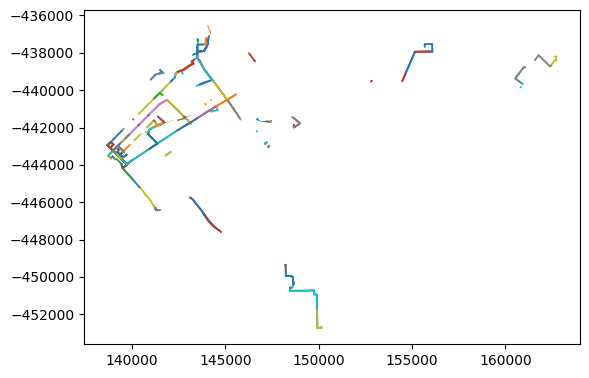

In [38]:
bbb.plot("segment_sequence")

<AxesSubplot:>

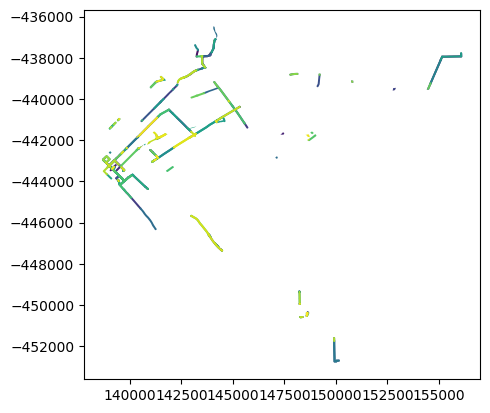

In [45]:
bbb_old.plot("hqta_segment_id")

In [39]:
all_clipped = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/high_quality_transit_areas/all_clipped.parquet")


In [42]:
metro_old = all_clipped[all_clipped.calitp_itp_id==182]
bbb_old = all_clipped[all_clipped.calitp_itp_id==300]